## ReTap - UPDRS-Tapping Assessment - Predictions

This notebooks investigates optimal hand- and fingertapping algorithms as part of the 
ReTune-Dyskinesia project.



### 0. Loading packages and functions, defining paths



In [1]:
# Importing Python and external packages
import os
import sys
import importlib
import json
import pandas as pd
import numpy as np
import sklearn as sk
import scipy
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec

import seaborn as sns
from scipy import signal
from scipy import stats
from array import array
import datetime as dt
from dataclasses import  dataclass, field
from itertools import compress
from typing import Any

In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
# print('mne_bids', mne_bids.__version__)
# print('mne', mne.__version__)
print('sci-py', scipy.__version__)
print('sci-kit learn', sk.__version__)


## developed with:
# Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
# [Clang 10.0.0 ]
# pandas 1.3.4
# numpy 1.20.3
# mne_bids 0.9
# mne 0.24.1
# sci-py 1.7.1
# sci-kit learn 1.0.1

## Currently (own env) since 31.08.22
# Python sys 3.9.12 (main, Jun  1 2022, 06:36:29) 
# [Clang 12.0.0 ]
# pandas 1.4.3
# numpy 1.21.5
# sci-py 1.7.3
# sci-kit learn 1.1.1

Python sys 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]
pandas 1.4.4
numpy 1.23.3
sci-py 1.9.1
sci-kit learn 1.1.2


In [27]:
# own functions
from retap_utils import utils_dataManagement
import retap_utils.get_datasplit as get_split

import tap_predict.tap_pred_prepare as pred_prep
import tap_predict.tap_pred_help as pred_help
import tap_plotting.retap_plot_clusters as plot_cluster

## 1) Split development and hold-out-test data sets

- Development data is used to train and test the model using iterative cross-validation
- Hold-out test data is NOT USED at all during cross-validation, and will be used to test the trained model as an external validation

### 1a. Import extracted Features

In [243]:
### IMPORT CREATED CLASSES FROM FILES

# import of feature classes is mandatory to use pickle below
from tap_extract_fts.main_featExtractionClass import FeatureSet, singleTrace

# define path with feature class
deriv_path = os.path.join(utils_dataManagement.get_local_proj_dir(), 'data', 'derivatives')

# ftClass = utils_dataManagement.load_class_pickle(os.path.join(deriv_path, 'ftClass_ALL_20221214.P'))
# ftClass10 = utils_dataManagement.load_class_pickle(os.path.join(deriv_path, 'ftClass_ALL_max10_20221214.P'))

newFts = utils_dataManagement.load_class_pickle(os.path.join(deriv_path, 'ftClass_ALL_20230301.P'))
newFts10 = utils_dataManagement.load_class_pickle(os.path.join(deriv_path, 'ftClass_max10_20230228.P'))
newFts15 = utils_dataManagement.load_class_pickle(os.path.join(deriv_path, 'ftClass_max15_20230228.P'))

In [426]:
subs = []
for t in newFts10.incl_traces:
    subs.append(getattr(newFts10, t).sub)

unique_subs = list(set(subs))

for cen in ['BER', 'DUS']:
    n = sum([cen in t for t in unique_subs])
    # print(f'# {n} included SUBS for {cen}')
    # n = sum([cen in t for t in newFts10.incl_traces])
    # print(f'# {n} included TRACES for {cen}')

## 2) ML-dataset Preparation

### Ensemble method: 1) score too few taps as 3, 2) cluster on tapping-frequency features, 3) K-Fold cv of Classification model

Create X1 with selected input features (mean and coef of variation of intra-tap-interval) and
overall tapping frequency to find two clusters (y_clusters) dividing fast vs slow tappers. 

In [265]:
# set variables for classification method
MAX_TAPS_PER_TRACE = None
USE_FT_CLASS = newFts
DATASPLIT = 'CROSSVAL'  # should be CROSSVAL or HOLDOUT
N_RANDOM_SPLIT = 41  # 01.03.23

SUBS_EXCL = ['BER028']  # too many missing acc-data
TRACES_EXCL = ['DUS006_M0S0_L_1']  # no score/video

SCORE_FEW_TAPS_3 = True
CUTOFF_TAPS_3 = 9

CLUSTER_ON_FREQ = False
N_CLUSTERS_FEQ = 2

In [38]:
### CHECK FOR MISSING ACC DATA IN TRACES
# for t in newFts.incl_traces:

#     sig = getattr(newFts, t).acc_sig
#     nan_ratio = sum(np.isnan(sig).any(axis=0)) / sig.shape[1]

#     if nan_ratio > 0: print(t, nan_ratio)

In [266]:
importlib.reload(get_split)

### GET DATA SPLIT CROSS-VAL OR HOLD-OUT
# get dict with dev and hold-out datasets
datasplit_subs = get_split.find_dev_holdout_split(
    feats=USE_FT_CLASS,
    subs_excl=SUBS_EXCL,
    traces_excl=TRACES_EXCL,
    # choose_random_split=None
)

if DATASPLIT == 'CROSSVAL': SUBS_EXCL.extend(datasplit_subs['hout'])
elif DATASPLIT == 'HOLDOUT': SUBS_EXCL.extend(datasplit_subs['cv'])



SPLITTING DATA IN DEV AND HOLD-OUT
Original score distribution: {0: 40, 1: 149, 2: 106, 3: 55, 4: 1}
Original score %: {0: 11.4, 1: 42.5, 2: 30.2, 3: 15.7, 4: 0.3}
Accepted Split: random state 41

Resulting distributions in splitted data sets:

	dev data set (n = 263):
score 0: # 30 (11 %)
score 1: # 109 (41 %)
score 2: # 81 (31 %)
score 3: # 43 (16 %)
score 4: # 0 (0 %)
	hout data set (n = 89):
score 0: # 10 (11 %)
score 1: # 40 (45 %)
score 2: # 26 (29 %)
score 3: # 12 (13 %)
score 4: # 1 (1 %)


In [267]:
### perform AFTER data split
if SCORE_FEW_TAPS_3:
    (
        classf_taps_3,
        y_pred_fewTaps,
        y_true_fewTaps
    ) = pred_help.classify_based_on_nTaps(
        max_n_taps=CUTOFF_TAPS_3,
        ftClass=USE_FT_CLASS,
        in_cv=True
    )
    # select traces from subs present in current datasplit
    datasplit_sel = [
        np.array([t.startswith(s) for s in datasplit_subs['dev']]).any()
        for t in classf_taps_3
    ]
    TRACES_EXCL.extend(list(compress(classf_taps_3, datasplit_sel)))
    y_pred_fewTaps = list(compress(y_pred_fewTaps, datasplit_sel))
    y_true_fewTaps = list(compress(y_true_fewTaps, datasplit_sel))

CLASSIFIED as 3 based on < 9 TAPS:
	['BER025_M0S0_R_1', 'BER025_M1S0_R_3', 'BER033_M0S0_R_2', 'BER023_M0S0_R_3', 'BER023_M0S0_R_2', 'BER023_M1S0_L_3', 'BER023_M1S0_L_2', 'BER023_M1S0_R_1', 'BER023_M1S0_R_2', 'BER023_M1S0_R_3', 'DUS006_M0S0_L_1', 'DUS026_M1S0_L_1', 'DUS017_M1S0_L_1', 'DUS017_M1S1_L_1', 'DUS022_M0S0_L_1']
	
true scores: [3 3 3 3 3 3 3 3 3 3 2 1 1 1 3]


### Make X_2 input Matrix with more features for score-prediction per Cluster

In [268]:
importlib.reload(pred_prep)

to_mask_4 = True
to_mask_0 = False
to_zscore = True
to_norm = False

CLASS_FEATS = [
    'trace_RMSn',
    'trace_entropy',
    'jerkiness_trace',

    'coefVar_intraTapInt',
    'slope_intraTapInt',
    'mean_tapRMS',
    'coefVar_tapRMS',
    'mean_impactRMS',
    'coefVar_impactRMS',
    'slope_impactRMS',
    'mean_raise_velocity',
    'coefVar_raise_velocity',
    'coefVar_tap_entropy',
    'slope_tap_entropy',

    # 'decr_intraTapInt',
    # 'mean_intraTapInt',  # out bcs of clustering (in for non-clustering)
    # 'decr_tapRMS',  # bcs slope dont steadily incr or decr
    # 'slope_tapRMS',
    # 'decr_raise_velocity',
    # 'slope_raise_velocity',

]

cv_data = pred_prep.create_X_y_vectors(
    USE_FT_CLASS,
    incl_traces=USE_FT_CLASS.incl_traces,
    incl_feats=CLASS_FEATS,
    excl_traces=TRACES_EXCL,
    excl_subs=SUBS_EXCL,  # due to hold out data set
    to_norm=to_norm,
    to_zscore=to_zscore,
    to_mask_4=to_mask_4,
    return_ids=True,
    as_class=True,
    mask_nans=True,
)

# create final dataframe with true and ensemble-predicted labels
# default all NaN's, filled during ensemble prediction
overall_perf = pd.DataFrame(
    data=np.array([[np.nan] * len(cv_data.y)] * 2).T,
    columns=['y_true', 'y_pred'],
    index=cv_data.ids,
)
overall_perf['y_true'] = cv_data.y

# of NaNs per feat: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [269]:
vars(newFts10.BER019_M0S0_L_1.fts).keys()

dict_keys(['triax_arr', 'fs', 'impacts', 'tap_lists', 'max_n_taps_incl', 'updrsSubScore', 'total_nTaps', 'freq', 'tap_durations', 'trace_RMSn', 'trace_entropy', 'intraTapInt', 'tapRMS', 'tapRMSnrm', 'impactRMS', 'raise_velocity', 'jerkiness_taps', 'jerkiness_trace', 'tap_entropy', 'mean_tapRMS', 'coefVar_tapRMS', 'IQR_tapRMS', 'decr_tapRMS', 'slope_tapRMS', 'mean_tapRMSnrm', 'coefVar_tapRMSnrm', 'IQR_tapRMSnrm', 'decr_tapRMSnrm', 'slope_tapRMSnrm', 'mean_impactRMS', 'coefVar_impactRMS', 'IQR_impactRMS', 'decr_impactRMS', 'slope_impactRMS', 'mean_raise_velocity', 'coefVar_raise_velocity', 'IQR_raise_velocity', 'decr_raise_velocity', 'slope_raise_velocity', 'mean_intraTapInt', 'coefVar_intraTapInt', 'IQR_intraTapInt', 'decr_intraTapInt', 'slope_intraTapInt', 'mean_jerkiness_taps', 'coefVar_jerkiness_taps', 'IQR_jerkiness_taps', 'decr_jerkiness_taps', 'slope_jerkiness_taps', 'mean_tap_entropy', 'coefVar_tap_entropy', 'IQR_tap_entropy', 'decr_tap_entropy', 'slope_tap_entropy'])

In [111]:
# # check for missing features (if nans are not masked above)
# for i, trace in enumerate(cv_data.ids):

#     if np.isnan(cv_data.X[i, :]).any():
#         print(trace,
#               np.array(CLASS_FEATS)[np.isnan(cv_data.X[i, :])])
#         print()


### OPTIONALLY. Split input matrix X_2 in two generated clusters:
- split X and y in two groups based on clusters
- test default ML modeling on both groups

In [272]:
importlib.reload(pred_prep)
importlib.reload(get_split)
importlib.reload(plot_cluster)
importlib.reload(pred_help)

# set variables for pre-clustering


CLUSTER_FEATS = [
    'mean_intraTapInt',
    'coefVar_intraTapInt',
    'freq'
]
to_mask_4 = True
to_mask_0 = False
to_zscore = True
to_norm = False

# # get dict with dev and hold-out datasets
# datasplit_subs = get_split.find_dev_holdout_split(
#     feats=USE_FT_CLASS,
#     subs_excl=SUBS_EXCL,
#     traces_excl=traces_excl,
#     choose_random_split=N_RANDOM_SPLIT
# )

# subs_excl_total = datasplit_subs['hout'].copy()  # both bcs of hold out
# subs_excl_total.extend(SUBS_EXCL)  # and bcs of a priori excl

# create dataclass for clustering (input matrix, label vector)
# only include dev, exclude hold-out
cluster_data = pred_prep.create_X_y_vectors(
    ftClass=USE_FT_CLASS,
    incl_feats=CLUSTER_FEATS,
    incl_traces=USE_FT_CLASS.incl_traces,
    excl_traces=TRACES_EXCL,
    excl_subs=SUBS_EXCL,  # excl hold out data
    to_zscore=to_zscore,
    to_norm=to_norm,
    to_mask_4=to_mask_4,
    to_mask_0=to_mask_0,
    return_ids=True,
    as_class=True
)

# create cluster labels
y_clusters, centr_clust, _ = plot_cluster.get_kMeans_clusters(
    X=cluster_data.X,
    n_clusters=N_CLUSTERS_FEQ,
    use_pca=True,
    to_zscore=to_zscore,
    to_norm=to_norm,
)

 # split pred_data in two clusters
(cv_fast_data, cv_slow_data) = pred_help.split_data_in_clusters(
    cv_data, y_clusters, cluster_data, CLUSTER_FEATS
)
print(f'Fast X shape: {cv_fast_data.X.shape}, Slow X shape: {cv_slow_data.X.shape}')


# of NaNs per feat: [0 0 0]


c:\Users\habetsj\Anaconda3\envs\retap\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


	cluster 0: -0.44354326588319587
	cluster 1: 1.4251554116902685
Fast X shape: (196, 14), Slow X shape: (61, 14)


### Visualise features in specific clusters

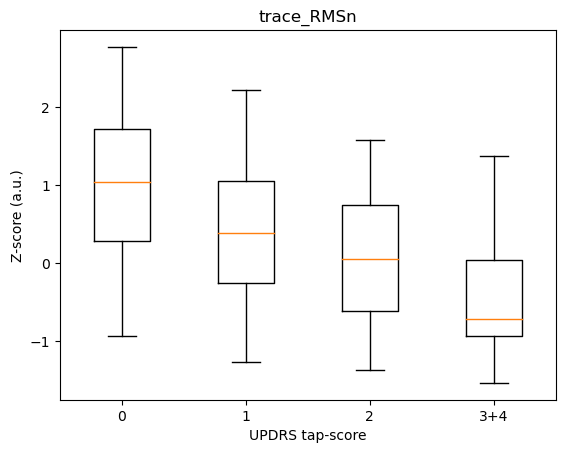

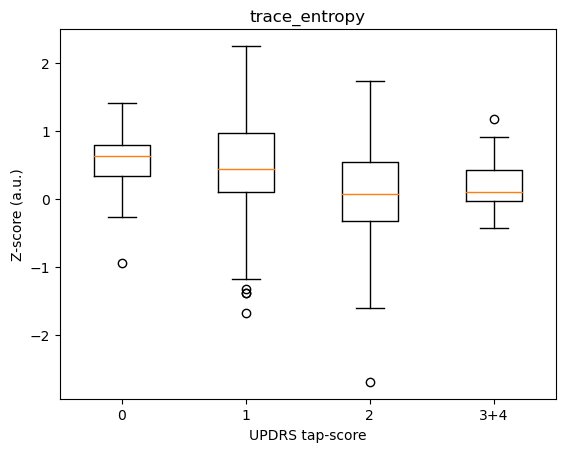

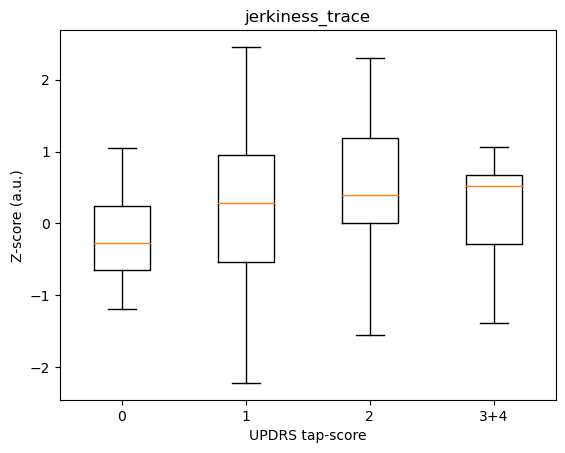

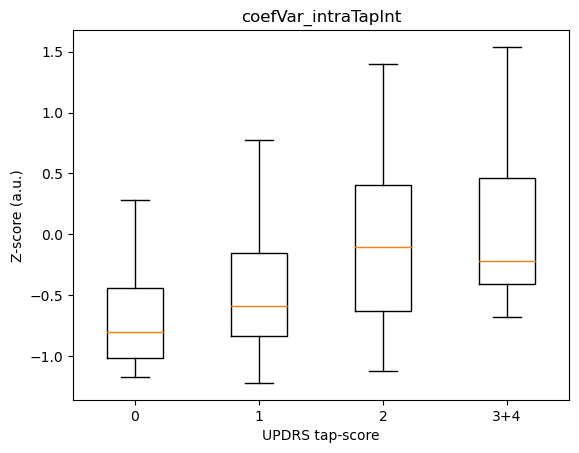

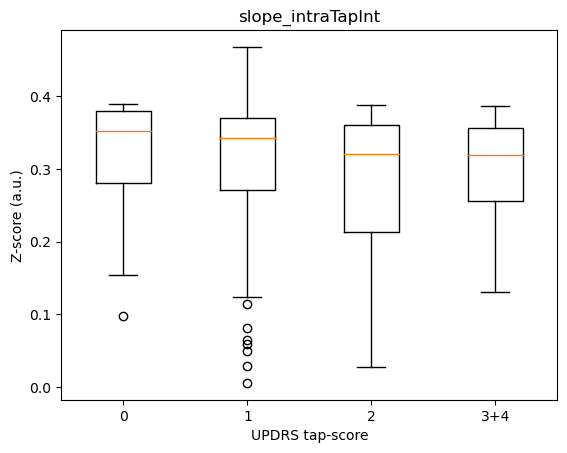

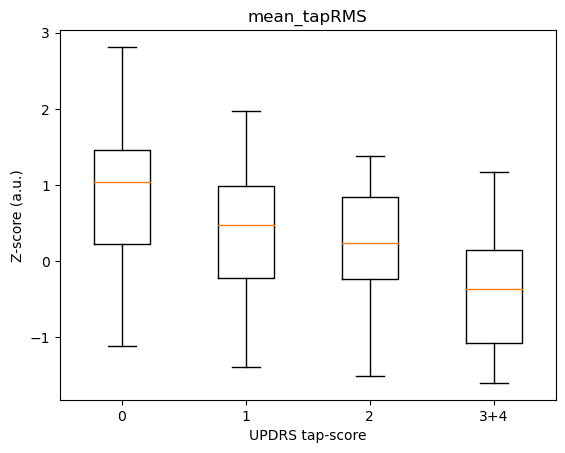

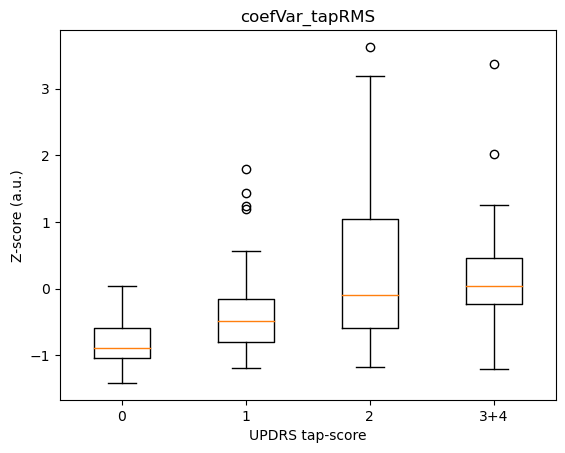

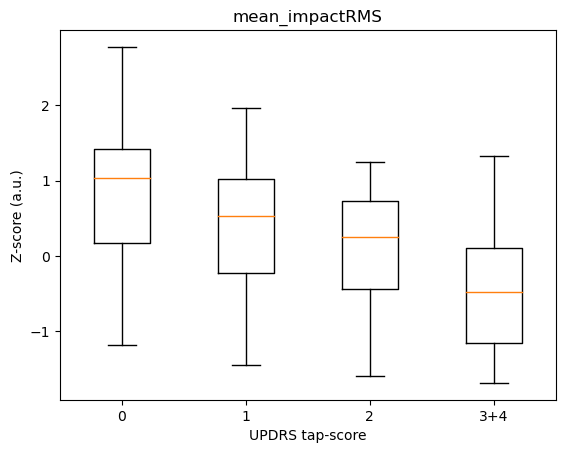

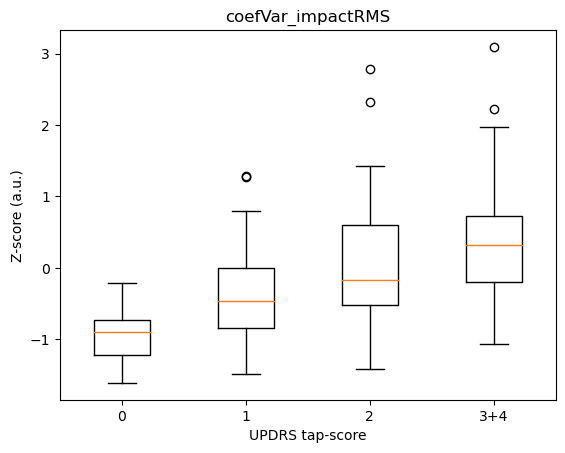

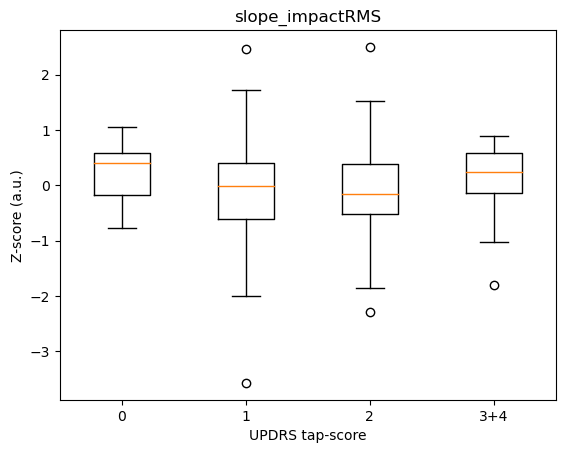

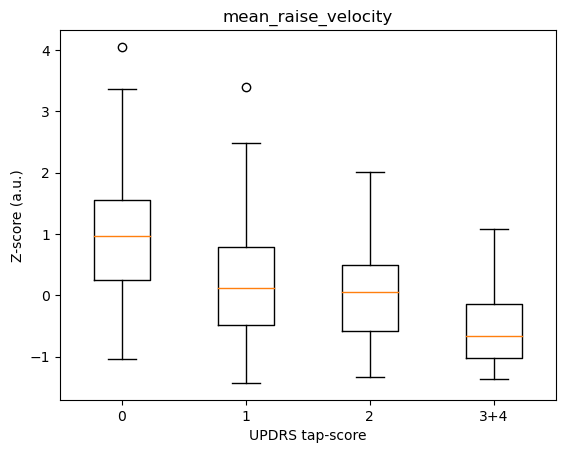

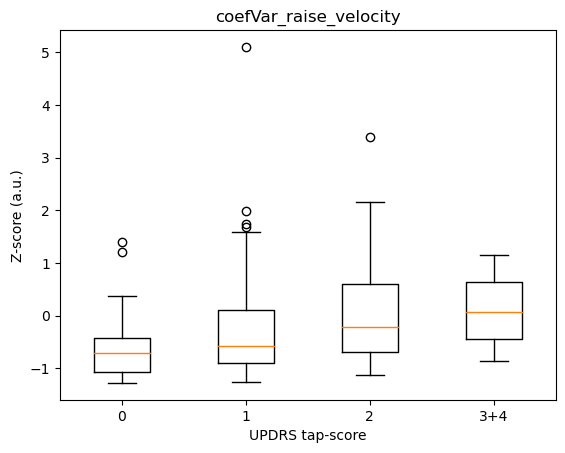

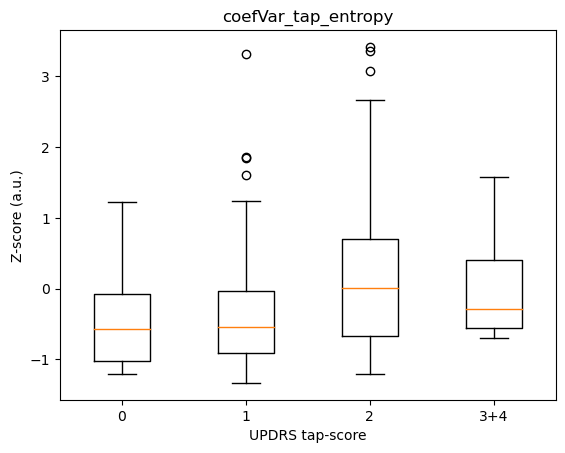

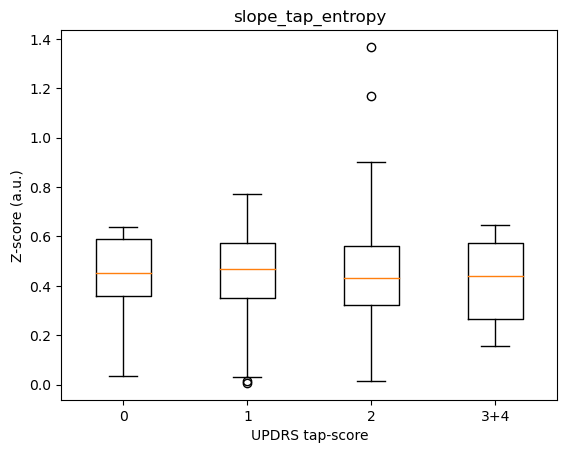

In [127]:
### PUT IN PLOTTING MODULE

# create lists for boxplots of features per subscore, per cluster

temp_data = cv_fast_data

# plot present tap-scores
temp_data_scores = [getattr(USE_FT_CLASS, t).tap_score for t in temp_data.ids]
temp_data_scores = [getattr(USE_FT_CLASS, t).tap_score for t in temp_data.ids]
score_counts = {y: temp_data_scores.count(y) for y in set(temp_data_scores)}
plt.bar(score_counts.keys(), score_counts.values())
plt.close()

box_lists = {}
for f in range(temp_data.X.shape[1]):
    box_lists[f] = {}
    for i in range(4): box_lists[f][i] = []


for i in np.arange(temp_data.X.shape[0]):

    score = temp_data.y[i]

    for f in range(temp_data.X.shape[1]):

        if np.logical_and(
            CLASS_FEATS[f].startswith('slope') or CLASS_FEATS[f].startswith('decr'),
            'entr' in CLASS_FEATS[f] or 'jerk' in CLASS_FEATS[f] or 'intraTap' in CLASS_FEATS[f]
        ):
            box_lists[f][int(score)].append(abs(temp_data.X[i, f]))

        else:
            box_lists[f][int(score)].append(temp_data.X[i, f])

# plot features within cluster, and decide on strategy
# pm: use pre-knowledge about clusters
# likelihood in faster cluster for 1-2 scores
# use probabilities and adapt the threshold for acceptance
# start finding border scores (e.g. 1 or 3)

for i_f, ft in enumerate(CLASS_FEATS):

    plot_lists = [box_lists[i_f][i] for i in range(4)]

    plt.boxplot(plot_lists)
    plt.title(ft)
    plt.xticks(range(1, len(plot_lists) + 1), labels=['0', '1', '2', '3+4'])
    plt.xlabel('UPDRS tap-score')
    plt.ylabel('Z-score (a.u.)')
    plt.show()

### Test hierarchichal prediction with Random Forest

- Boolean Classification seemed inferior compared to MultiClass RF

    optimal thresholds (to prevent too large False Positive Values)
    predicting the best tappers (0-1)
    - (best) RandomForest, cutoff .75 (TPR ~ .75-.8, FPR ~ .15)
    - .58 - .6 for LogReg
    - .6 for svm linear kernel
    - .6 for svm poly kernel

    indicating updrs 3 chance for next step
    - .15 for log reg and lda (svc not succesful)

In [273]:
from tap_predict import retap_cv_models as cv_models
from tap_plotting import plot_cv_folds as plot_folds

from sklearn.model_selection import StratifiedKFold

#### Predict Fast Cluster

In [274]:
from sklearn.metrics import cohen_kappa_score as kappa  


In [275]:
importlib.reload(cv_models)
importlib.reload(plot_folds)

# CLassification Settings
temp_data = cv_fast_data  # data to use here
score_to_predict = 3
clf_choice = 'RF'
nFolds = 3
to_plot = True

multiclass = True

if multiclass:
    y_pred_true = temp_data.y
    mc_labels = ['0', '1', '2', '3-4']

else:
    if score_to_predict == 1:
        y_pred_true = temp_data.y <= score_to_predict
        plot_thresholds = [.65, .7, .75]
        roc_title = f'Identify UPDRS 0/1 vs Rest ({clf_choice})'

    elif score_to_predict == 3:
        y_pred_true = temp_data.y == score_to_predict
        plot_thresholds = [.25, .4, .5]
        roc_title = f'Identify UPDRS 3-4 vs Rest ({clf_choice})'


(y_pred_dict, y_proba_dict,
 y_true_dict, og_pred_idx
) = cv_models.get_cvFold_predictions_dicts(
    X_cv=temp_data.X,
    y_cv=y_pred_true,
    cv_method=StratifiedKFold,
    n_folds=nFolds,
    clf=clf_choice,
)
if to_plot and not multiclass: 
    plot_folds.plot_ROC_AUC_confMatrices_for_folds(
        y_true_dict=y_true_dict,
        y_proba_dict=y_proba_dict,
        plot_thresholds=plot_thresholds,
        roc_title=roc_title,
    )
if multiclass:
    cm = cv_models.multiclass_conf_matrix(
        y_true=y_true_dict, y_pred=y_pred_dict,
        labels=mc_labels,
    )
    



RandomForestClassifier(class_weight='balanced', min_samples_split=5,
                       n_estimators=500, random_state=27)
Fold 0: # of samples: train 130, test 66
Fold 1: # of samples: train 131, test 65
Fold 2: # of samples: train 131, test 65



Confusion Matrix:
Predicted Scores   0   1   2  3-4
True Scores                      
0                  1  23   1    0
1                 13  57  25    1
2                  2  31  19    4
3-4                0   6   9    4
mean UPDRS-penalty: 0.64 (+/- 0.58)
Kappa: 0.18278852568378923, R: SpearmanrResult(correlation=0.34066909021691544, pvalue=1.0300917859910873e-06)


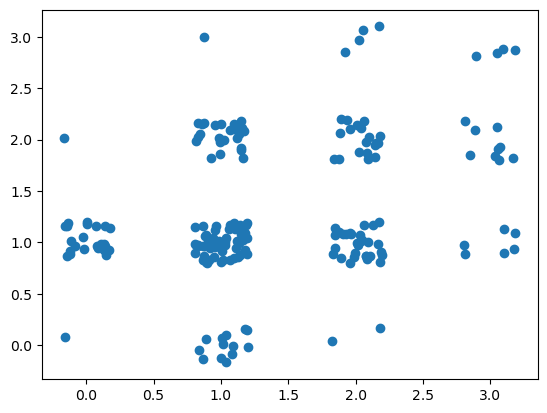

In [276]:
print(f'\nConfusion Matrix:\n{cm}')
mean_pen, std_pen, _ = cv_models.get_penalties_from_conf_matr(cm)
print(f'mean UPDRS-penalty: {round(mean_pen, 2)}'
        f' (+/- {round(std_pen, 2)})')
y_true_temp, y_pred_temp = [], []

for f in np.arange(len(y_true_dict)):
    y_true_temp.extend(y_true_dict[f])
    y_pred_temp.extend(y_pred_dict[f])

k_score = kappa(y_true_temp, y_pred_temp, weights='linear')
fast_true = y_true_temp
fast_pred = y_pred_temp

print(f'Kappa: {k_score}, '
      f'R: {scipy.stats.spearmanr(y_true_temp, y_pred_temp)}')

jitt = np.random.uniform(low=-.2, high=0.2, size=len(y_true_temp))
jitt2 = np.random.uniform(low=-.2, high=0.2, size=len(y_true_temp))
plt.scatter(y_true_temp+jitt, y_pred_temp+jitt2)
plt.show()

### Test Slow Tapper Cluster

In [277]:
importlib.reload(cv_models)
importlib.reload(plot_folds)

# CLassification Settings
temp_data = cv_slow_data  # data to use here
clf_choice = 'RF'
nFolds = 3
mask_0 = False
multiclass = True
score_to_predict = 3

y_model = temp_data.y.copy()
if mask_0: # mask 0's to 1
    y_model[y_model == 0] = 1
    mc_labels = ['0-1', '2', '3-4']
else:
    mc_labels = ['0', '1', '2', '3-4']

if not multiclass:
    y_model = y_model == score_to_predict
    to_plot = True

    if score_to_predict == 1:
        plot_thresholds = [.65, .7, .75]
        roc_title = f'Identify UPDRS 0/1 vs Rest ({clf_choice})'

    elif score_to_predict == 3:
        plot_thresholds = [.25, .4, .5]
        roc_title = f'Identify UPDRS 3-4 vs Rest ({clf_choice})'

# print descriptives
n_samples = len(temp_data.ids)
print(f'Included # of traces: {n_samples}')
y_scores, counts = np.unique(y_model, return_counts=True)
for s, c in zip(y_scores, counts):
    print(f'\tscore {s}: # {c} ({round(c / n_samples * 100)} %)')


(y_pred_dict, y_proba_dict,
 y_true_dict, og_pred_idx
) = cv_models.get_cvFold_predictions_dicts(
    X_cv=temp_data.X,
    y_cv=y_model,
    cv_method=StratifiedKFold,
    n_folds=nFolds,
    clf=clf_choice,
)
if to_plot and not multiclass: 
    plot_folds.plot_ROC_AUC_confMatrices_for_folds(
        y_true_dict=y_true_dict,
        y_proba_dict=y_proba_dict,
        plot_thresholds=plot_thresholds,
        roc_title=roc_title,
    )
if multiclass:
    cm = cv_models.multiclass_conf_matrix(
        y_true=y_true_dict, y_pred=y_pred_dict,
        labels=mc_labels,
    )
    


Included # of traces: 61
	score 0: # 5 (8 %)
	score 1: # 12 (20 %)
	score 2: # 24 (39 %)
	score 3: # 20 (33 %)
RandomForestClassifier(class_weight='balanced', min_samples_split=5,
                       n_estimators=500, random_state=27)
Fold 0: # of samples: train 40, test 21
Fold 1: # of samples: train 41, test 20
Fold 2: # of samples: train 41, test 20



Confusion Matrix:
Predicted Scores  0  1   2  3-4
True Scores                    
0                 1  3   1    0
1                 0  5   5    2
2                 0  5  13    6
3-4               1  4   2   13
mean UPDRS-penalty: 0.62 (+/- 0.75)
Kappa: 0.35931453841901606, R: SpearmanrResult(correlation=0.40321802354262976, pvalue=0.0012727377273392358)


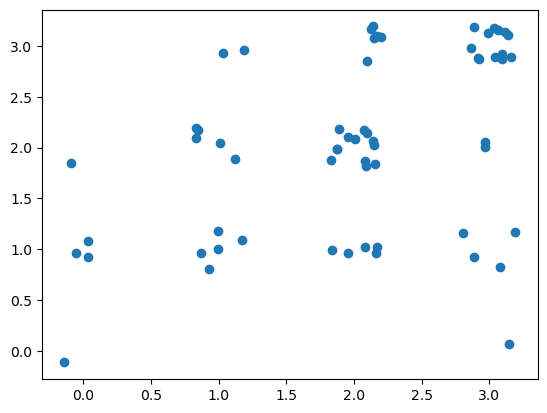

In [278]:
print(f'\nConfusion Matrix:\n{cm}')
mean_pen, std_pen, _ = cv_models.get_penalties_from_conf_matr(cm)
print(f'mean UPDRS-penalty: {round(mean_pen, 2)}'
        f' (+/- {round(std_pen, 2)})')



y_true_temp, y_pred_temp = [], []

for f in np.arange(len(y_true_dict)):
    y_true_temp.extend(y_true_dict[f])
    y_pred_temp.extend(y_pred_dict[f])

k_score = kappa(y_true_temp, y_pred_temp, weights='linear')
slow_true = y_true_temp
slow_pred = y_pred_temp

print(f'Kappa: {k_score}, '
      f'R: {scipy.stats.spearmanr(y_true_temp, y_pred_temp)}')

jitt = np.random.uniform(low=-.2, high=0.2, size=len(y_true_temp))
jitt2 = np.random.uniform(low=-.2, high=0.2, size=len(y_true_temp))
plt.scatter(y_true_temp+jitt, y_pred_temp+jitt2)


Confusion Matrix:
Predicted Scores   0   1   2  3-4
True Scores                      
0                  2  26   2    0
1                 13  62  30    4
2                  2  36  32   11
3-4                1  10  11   21
mean UPDRS-penalty: 0.63 (+/- 0.63)
Kappa: 0.3158022850709712, R: SpearmanrResult(correlation=0.44702690296157765, pvalue=2.5209260436829386e-14)


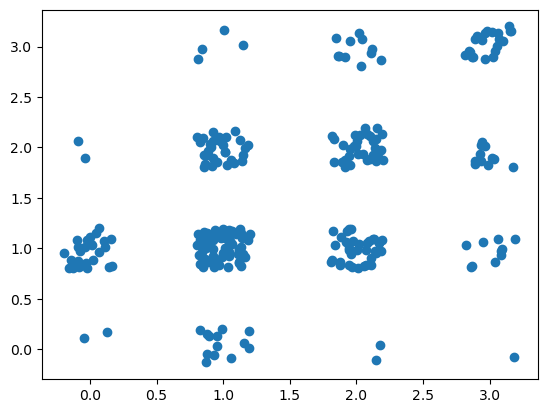

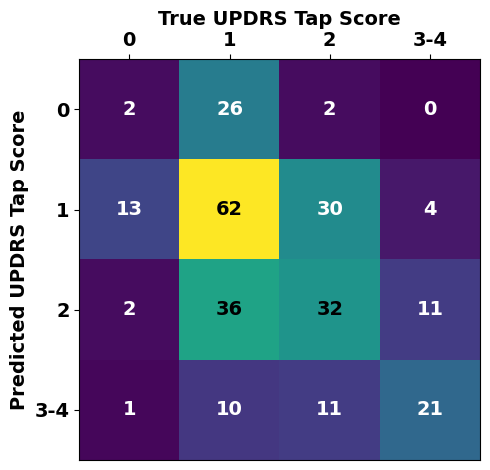

In [299]:
### COMBINE FAST AND SLOW CLUSTER OUTCOMES

true_clusters = [l for l in [fast_true, slow_true, y_true_fewTaps]]
true_clusters = [s for l in true_clusters for s in l]

pred_clusters = [l for l in [fast_pred, slow_pred, y_pred_fewTaps]]
pred_clusters = [s for l in pred_clusters for s in l]

cm = cv_models.multiclass_conf_matrix(
      y_true=true_clusters, y_pred=pred_clusters,
      labels=mc_labels,
)
print(f'\nConfusion Matrix:\n{cm}')
mean_pen, std_pen, _ = cv_models.get_penalties_from_conf_matr(cm)
print(f'mean UPDRS-penalty: {round(mean_pen, 2)}'
        f' (+/- {round(std_pen, 2)})')

print(f'Kappa: {k_score}, '
      f'R: {scipy.stats.spearmanr(true_clusters, pred_clusters)}')

jitt = np.random.uniform(low=-.2, high=0.2, size=len(true_clusters))
jitt2 = np.random.uniform(low=-.2, high=0.2, size=len(pred_clusters))
plt.scatter(true_clusters+jitt, pred_clusters+jitt2)
plt.show()

fig, ax = plt.subplots(1, 1)
im = ax.imshow(cm.values)

# Show all ticks and label them with the respective list entries
ax.xaxis.tick_top()
ax.set_xticks(np.arange(len(mc_labels)))
ax.set_yticks(np.arange(len(mc_labels)))
ax.set_xticklabels(mc_labels, weight='bold', fontsize=fs)
ax.set_yticklabels(mc_labels, weight='bold', fontsize=fs, )
ax.xaxis.set_label_position('top')
ax.set_xlabel('True UPDRS Tap Score', weight='bold', fontsize=fs, )
ax.set_ylabel('Predicted UPDRS Tap Score', weight='bold', fontsize=fs)

# Loop over data dimensions and create text annotations.
for i in range(len(mc_labels)):
    for j in range(len(mc_labels)):
        value = cm.values[i, j]
        if value > 30: txt_col ='k'
        else: txt_col = 'w'
        text = ax.text(
            j, i, value, weight='bold', fontsize=fs,
            ha="center", va="center", color=txt_col,
      )

plt.tight_layout()

plt.show()

### Test all Tappers (without clustering)

In [280]:
importlib.reload(cv_models)
importlib.reload(plot_folds)

ADD_FEW_TAPS = True

# CLassification Settings
temp_data = cv_data  # data to use here
clf_choice = 'RF'
nFolds = 6
mask_0 = False
multiclass = True
score_to_predict = 3
to_plot=True

y_model = temp_data.y.copy()
if mask_0: # mask 0's to 1
    y_model[y_model == 0] = 1
    mc_labels = ['0-1', '2', '3-4']
else:
    mc_labels = ['0', '1', '2', '3-4']

if not multiclass:
    y_model = y_model == score_to_predict
    to_plot = True

    if score_to_predict == 1:
        plot_thresholds = [.65, .7, .75]
        roc_title = f'Identify UPDRS 0/1 vs Rest ({clf_choice})'

    elif score_to_predict == 3:
        plot_thresholds = [.25, .4, .5]
        roc_title = f'Identify UPDRS 3-4 vs Rest ({clf_choice})'


(y_pred_dict, y_proba_dict,
y_true_dict, og_pred_idx
) = cv_models.get_cvFold_predictions_dicts(
    X_cv=temp_data.X,
    y_cv=y_model,
    cv_method=StratifiedKFold,
    n_folds=nFolds,
    clf=clf_choice,
    verbose=False,
)
if to_plot and not multiclass: 
    plot_folds.plot_ROC_AUC_confMatrices_for_folds(
        y_true_dict=y_true_dict,
        y_proba_dict=y_proba_dict,
        plot_thresholds=plot_thresholds,
        roc_title=roc_title,
        # verbose=False,
    )
if multiclass:

    if ADD_FEW_TAPS:
        n_dict = nFolds
        y_true_dict[n_dict] = y_true_fewTaps
        y_pred_dict[n_dict] = y_pred_fewTaps

    cm = cv_models.multiclass_conf_matrix(
        y_true=y_true_dict, y_pred=y_pred_dict,
        labels=mc_labels,
    )
    


In [225]:
import tap_plotting.plot_pred_results as plot_results

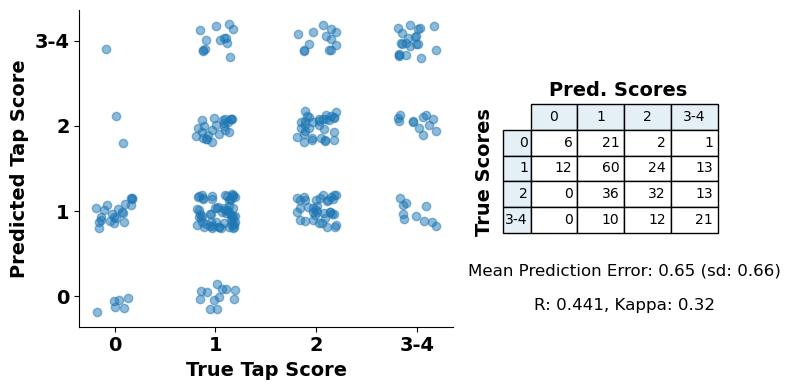

In [281]:
importlib.reload(plot_results)
y_true_temp, y_pred_temp = [], []

for f in np.arange(len(y_true_dict)):
    y_true_temp.extend(y_true_dict[f])
    y_pred_temp.extend(y_pred_dict[f])

k_score = kappa(y_true_temp, y_pred_temp, weights='linear')
R, R_p = scipy.stats.spearmanr(y_true_temp, y_pred_temp)



plot_results.plot_confMatrix_scatter(
    y_true_temp, y_pred_temp,
    R=R, K=k_score, CM=cm,
    to_save=False, to_show=True, fname='Unclustered'
)



## Test for Significance using Permutation Tests with shuffeld labels

In [ ]:
from retap_utils.utils_dataManagement import find_onedrive_path

#### A) Create Permutation Results based on random picking of outcome without Classification Modeling

In [38]:
n_permutations = 500

penalties_full_chance = []
true_labels = overall_perf['y_true'].values

r_states = np.linspace(0, 1000, n_permutations).astype(int)

for r_seed in r_states:
    np.random.seed(r_seed)
    random_labels = np.random.randint(0, 3 + 1, size=len(true_labels))
    diffs = abs(true_labels - random_labels)
    penalties_full_chance.append(diffs.mean())

print(
    'Mean Penalty without distribution'
    f' knowledge: {round(np.mean(penalties_full_chance), 3)}')
print(
    'Penalty alpha .05 cut off without distribution'
    f' knowledge: {round(np.percentile(penalties_full_chance, 5), 3)}')

Mean Penalty without distribution knowledge: 1.134
Penalty alpha .05 cut off without distribution knowledge: 1.06


#### B) Create MultiClass Permutation Results based Classification of Shuffled or Random Labels

- Optionally: Population-Matched (weighted) Distribution of UPDRS scores
- TODO: Repeat with n_permutations = 500

In [152]:
importlib.reload(cv_models)
importlib.reload(plot_folds)

"""
Run permutation test
    +/- 3-5 seconds per permutation round
"""

# Permutation settings
random_base_seed = 27  # never changes, to ensure same results in randomisation
n_permutations = 2
match_label_distribution = False  # take same UPDRS score distribution as real labels
to_save_perms = True
# CV settings
clf_choice = 'RF'
nFolds = 6
mask_0 = False


# Perm settings
np.random.seed(random_base_seed)
perm_errors = {'mean': [], 'lists': []}
r_states = np.random.choice(5000, size=n_permutations, replace=False)

# CLassification Settings
y_orig = cv_data.y.copy()  # multiclass labels 0-1-2-3(4)
X_orig = cv_data.X.copy()

if mask_0: # mask 0's to 1
    y_model[y_model == 0] = 1
    min_label = 1
    mc_labels = ['0-1', '2', '3-4']
else:
    min_label = 0
    mc_labels = ['0', '1', '2', '3-4']

# Perform Permutations
for n_prm, r_seed in enumerate(r_states):
    print(f'Start permutation iteration {n_prm} (random seed {r_seed})')
    np.random.seed(r_seed)
    # Create random y-labels
    if match_label_distribution:
        # Create random y-labels with same distribution of scores
        y_perm = y_orig.copy()  # copy true y-labels
        np.random.shuffle(y_perm)  # shuffle true y-labels

    elif not match_label_distribution:
        # take random set of labels between 0 and (incl) 3
        y_perm = np.random.randint(min_label, 3 + 1, size=len(true_labels))

    # Perform random Classification
    (y_pred_dict,
     y_proba_dict,
     y_true_dict,
     og_pred_idx) = cv_models.get_cvFold_predictions_dicts(
        X_cv=X_orig,
        y_cv=y_perm,
        cv_method=StratifiedKFold,
        n_folds=nFolds,
        clf=clf_choice,
        verbose=False,
    )
    # Create MultiClass Conf Matrix
    cm = cv_models.multiclass_conf_matrix(
        y_true=y_true_dict, y_pred=y_pred_dict,
        labels=mc_labels,
    )
    (mean_error,
     std_error,
     error_list) = cv_models.get_penalties_from_conf_matr(cm)
    # Add permuted scores to lists
    perm_errors['mean'].append(mean_error)
    perm_errors['lists'].append(error_list)

if to_save_perms:
    save_dir = os.path.join(find_onedrive_path('results'),
                            'predictions', 'permutations')
    fname = f'PermErrors_CvDevData_{clf_choice}_n{n_permutations}'
    if match_label_distribution: fname += '_weightedLabels'
    else: fname += '_randomLabels'

    if not os.path.exists(save_dir): os.makedirs(save_dir)

    temp = np.array(perm_errors['lists'])
    temp = pd.DataFrame(temp.T)  # rows are n-samples, columns are n-perms
    # np.savetxt(
    temp.to_csv(os.path.join(save_dir, f'{fname}.csv'),
                sep=',', header=False, index=False,
                float_format=np.float32)
    print(f'Permutations succesfully saved as: {fname}')


Start permutation iteration 0 (random seed 1)
Start permutation iteration 1 (random seed 1489)
Permutations succesfully saved as: PermErrors_CvDevData_RF_n2_randomLabels


#### C) Load and Plot Prediction Results vs Permutation Results

In [175]:
from retap_utils.utils_dataManagement import find_onedrive_path

n_perm = 5
alpha = .05
save_fig=False

# fname = f'PermErrors_CvDevData_{clf_choice}_n{n_permutations}'
# if match_label_distribution: fname += '_weightedLabels'
# else: fname += '_randomLabels'
# fname = f'RF_full_dev_data_{n_perm}perms_means.csv'
fname = 'PermErrors_CvDevData_RF_n5_weightedLabels.csv'
perm_dir = os.path.join(
    find_onedrive_path('results'),
    'predictions', 'permutations')

# get mean error per permutation iteration
perm_error_lists = np.genfromtxt(os.path.join(perm_dir, fname), delimiter=',')
if perm_error_lists.shape[0] == n_perm:
    mean_errors = perm_error_lists.mean(axis=1)
elif perm_error_lists.shape[1] == n_perm:
    mean_errors = perm_error_lists.mean(axis=0)
else:
    raise ValueError('Incorrect # shape of loaded Permutation Errors')
# get alpha significance border
sign_05 = round(np.percentile(mean_errors, alpha * 100), 2)

# Plot Results
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

plt.rc('font', size=14)

ymin, ymax = ax.get_ylim()
# plot Real cross-validation prediction mean
ax.axvline(.74, lw=3, ymin=ymin, ymax=ymax, color='darkgreen',
           label=f'mean (unclustered)\ncross-val predictions')
# plot permutation test results
ax.hist(mean_errors, color='darkblue', hatch='/', alpha=.5,
        label=f'balanced permutations -\nprediction means (n={n_perm})',)
# ax.hist(penalties_full_chance, color='purple', hatch='//', alpha=.2,
#         label=f'unbalanced permutations -\nprediction means (n={n_perm})',)
ax.axvline(sign_05, ymin=ymin, ymax=ymax, color='darkblue',
           ls='--', label=f'alpha=0.05\n(balanced)')
# ax.axvline(1.06, ymin=ymin, ymax=ymax, color='purple',
#            ls='--', label=f'alpha=0.05\n(unbalanced)')


ax.set_xlabel('Mean Prediction Error (UPDRS tap-score)')
ax.set_ylabel('observations (#)')
ax.legend(frameon=False, fontsize=12, ncol=1,
          bbox_to_anchor=(.90, .99), loc='upper left',)
for side in ['right', 'top']:
    getattr(ax.spines, side).set_visible(False)
plt.xlim(.65, 1.3)
plt.ylim(0, 50)
plt.tight_layout()
if save_fig:
    fname='RF_prediction_vs_200permutations_test'
    plt.savefig(
        os.path.join(find_onedrive_path('figures'),
                    'prediction', fname),
        facecolor='w', dpi=150,)
plt.close()

#### Rating Agreements with Cohen's Kappa

In [17]:
from sklearn.metrics import cohen_kappa_score as kappa  # k_score = kappa(y_true, y_pred)  # 1 is perfect, 0 is chance

## 4) PM Traditional Descriptive Statistics

- Candidate vetors based on descriptives and concept
    - nTaps
    - freq
    - upVelo sum [std-dev + coefVar]
    - impact RMS [coefVar + stddev]
    - tapRMS and impactRMS [sum]
    - 
- include per run (array tap-features): sum, mean, stddev, trend_slope

- Cluster on UPDRS 4?

#### MANOVA

- normality assumption violated (Shapiro test highly significant)
- for every a priori selected feature: present difference between sub-score-groups is a Kruskal-Wallis test (non-parametric One-Way ANOVA alternative)
- differences between two sub groups within a feature is a non-parametric test of two groups of quantitative values (likely varying lengths): Mann-Whitney-U
- in total: correct alpha for number of repeated measures on specific level

In [41]:
# from scipy.stats import shapiro
# for col in np.arange(X.shape[1]):
#     print(feats[col], shapiro(X[:, col]))

In [40]:
# from statsmodels.multivariate.manova import MANOVA

# stat_data = np.concatenate([X, y.reshape((len(y), 1))], axis=1)
# manova_df = pd.DataFrame(
#     data=stat_data,
#     columns=feats + ['subscore'],
# )
# maov = MANOVA.from_formula(
#     'nTaps + freq + mean_intraTapInt + coefVar_intraTapInt + IQR_jerkiness +'
#     ' mean_raise_velocity + mean_tapRMSnrm ~ subscore ',
#     # 'mean_jerkiness_smooth + IQR_jerkiness_smooth ~ subscore',
#     data=manova_df,
# )
# print(maov.mv_test())

In [39]:
# from scipy.stats import kruskal
# importlib.reload(pred_prep)

# mask_scores = True

# traces, feats = pred_prep.select_traces_and_feats(
#     ftClass,
#     center=center_incl,
#     use_sel_fts=sel_feats,
# )
# X, y = pred_prep.create_X_y_vectors(
#     ftClass,
#     incl_traces=traces,
#     incl_feats=feats,
#     to_norm=False,
# )
# n_groups = 5
# if mask_scores:
#     # UPDRS 4 -> 3 merge
#     mask = y == 4
#     y[mask] = 3
#     # UPDRS 0 -> 1 merge
#     mask = y == 0
#     y[mask] = 1

#     n_groups = 3

# stat_data = np.concatenate([X, y.reshape((len(y), 1))], axis=1)
# stat_df = pd.DataFrame(
#     data=stat_data,
#     columns=feats + ['subscore'],
# )

# stat_fts = [
#     'freq', 'coefVar_intraTapInt', 'mean_jerkiness', 'coefVar_jerkiness',
#     'mean_tapRMSnrm', 'coefVar_tapRMSnrm', 'slope_tapRMSnrm'
# ]
# alpha = .05 / len(stat_fts)
# for ft in stat_fts:
#     tempft = stat_df[~np.isnan(stat_df[ft])]

    
#     if mask_scores:
#         groups = [
#             tempft[ft][tempft['subscore'] == s].reset_index(drop=True)
#             for s in np.arange(1, n_groups + 1)
#         ]
#         krusk_stat, krusk_p = kruskal(
#             groups[0], groups[1], groups[2], 
#         )
#     else:
#         groups = [
#             tempft[ft][tempft['subscore'] == s].reset_index(drop=True)
#             for s in np.arange(n_groups)
#         ]
#         krusk_stat, krusk_p = kruskal(
#             groups[0], groups[1], groups[2], 
#             groups[3], groups[4]
#         )
#     print(f'\n{ft}: \n\tGroup level sign. difference (Kruskal'
#         f' Test): {krusk_p < alpha} (p = {np.round(krusk_p, 6)})\n')
#     for g in np.arange(n_groups - 1):

#         mnwu_rho, mnwu_p = mannwhitneyu(groups[g], groups[g + 1])
#         print(f'\tupdrs {g} vs {g + 1} sign, (Mann-Whitney-U): '
#             f'{mnwu_p < (alpha / (n_groups - 1))} (p = {np.round(mnwu_p, 6)})')


In [ ]:
### additional methods for none multiclass prediction

# importlib.reload(pred_prep)

### Extract best tappers (0-1 predicted) from fast-tappers and classify remaining part

# # Set Final Prediction best fast-tappers to 1
# set_outcome = True
# data_fast_01, data_fast_rest = pred_prep.split_dataset_on_pred_proba(
#     orig_dataset=cv_fast_data,
#     probas=y_proba_dict,
#     og_indices=og_pred_idx,
#     proba_thr=.75,
# )
# if set_outcome:
#     for trace_id in data_fast_01.ids:
#         overall_perf.at[trace_id, 'y_pred'] = 1


#### Identify UPDRS 3 in remaining fast tappers

# - use positive prediction for UPDRS III in previous step (which is not used for splitting data)
# - opt logreg threshold for updrs-3: .18
# - opt lda threshold for updrs-3: .3

### INCLUDE UPDRS 3 LABELS FROM RPEVIOUS TEP

# importlib.reload(cv_models)
# n_samples = len(data_fast_rest.ids)
# print(f'Remaining # of traces: {n_samples}')
# y_scores, counts = np.unique(data_fast_rest.y, return_counts=True)
# for s, c in zip(y_scores, counts):
#     print(f'\tscore {s}: # {c} ({round(c / n_samples * 100)} %)')


# multiclass = True
# clf_choice = 'rf'
# to_plot=True
# mask_0 = True

# y_model = data_fast_rest.y.copy()
# if mask_0: # mask 0's to 1
#     y_model[y_model == 0] = 1
#     mc_labels = ['0-1', '2', '3-4']
# else:
#     mc_labels = ['0', '1', '2', '3-4']

# if not multiclass:
#     y_model = y_model >= 2

# plot_thresholds=[.5, .6, .7]
# roc_title=f'Rest Fast-Tappers == UPDRS 2/3 ({clf_choice})'


# (cv_pred, cv_proba, cv_true, cv_idx
# ) = cv_models.get_cvFold_predictions_dicts(
#     X_cv=data_fast_rest.X,
#     y_cv=y_model,
#     n_folds=3,
#     clf=clf_choice,
# )

# if clf_choice == 'lda': thresh3 = .3
# elif clf_choice == 'logreg': thresh3 = .3

# ids_pos_3 = []
# for fold in cv_proba:
#     for i_prob, proba in enumerate(cv_proba[fold]):
#         if proba[1] > thresh3:
#             og_i = cv_idx[fold][i_prob]
#             ids_pos_3.append(
#                 data_fast_rest.ids[og_i]
#             )

# if to_plot and not multiclass: 
#     plot_folds.plot_ROC_AUC_confMatrices_for_folds(
#         y_true_dict=cv_true,
#         y_proba_dict=cv_proba,
#         plot_thresholds=plot_thresholds,
#         roc_title=roc_title,
#         incl_mean_ROC=True,
#     )
# if multiclass:
#     cm = cv_models.multiclass_conf_matrix(
#         y_true=cv_true, y_pred=cv_pred,
#         labels=mc_labels,
#     )
#     print(f'\nConfusion Matrix:\n{cm}')
#     mean_pen, std_pen, _ = cv_models.get_penalties_from_conf_matr(cm)
#     print(f'mean UPDRS-penalty: {round(mean_pen, 2)}'
#             f' (+/- {round(std_pen, 2)})')